In [67]:
import librosa
from aubio import source, onset
import numpy as np
import math
import os
from os.path import join
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [2]:
wav_lst = os.listdir('outputs')
sr = 24000

FileNotFoundError: [Errno 2] No such file or directory: 'outputs'

## Librosa

In [60]:
def librosa_onsets(file_path, fs=24000, mode='env'):
    signal, fs = librosa.load(file_path, sr=fs)
    
    if mode == 'time':
        ### wait: gap between peaks; pre/post_max/avg: windowing; delta: threshold ###
        onset_ts = librosa.onset.onset_detect(signal, sr=fs, units='time', backtrack=True, 
                                              wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1, delta=0.1)
        #onset_ts = librosa.onset.onset_detect(signal, sr=fs, units='time', backtrack=True)
    elif mode == 'env':
        o_env = librosa.onset.onset_strength(signal, sr=fs)
        times = librosa.times_like(o_env, sr=fs)
        onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=fs, backtrack=True)
        onset_ts = librosa.frames_to_time(onset_frames)
        
        D = np.abs(librosa.stft(signal))
        fig, ax = plt.subplots(1, 1)
        ax.set_title('Librosa Onset Detection')
        ax.plot(times, o_env, label='Onset strength')
        ax.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
        ax.legend()
        ax.set_xlabel('Time (s)')
    else:
        raise ValueError("Do not support this mode!")
        
    return onset_ts

In [24]:
signal ,fs = librosa.load(join('outputs', wav_lst[0]), sr=sr)

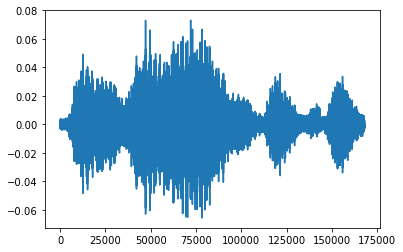

In [25]:
plt.plot(signal)
plt.show()

array([  3,   5,  14,  20,  27,  33,  35,  42,  45,  53,  55,  60,  66,
        72,  79,  83,  86,  97, 107, 113, 117, 122, 124, 129, 132, 134,
       140, 142, 145, 147, 150, 155, 157, 160, 163, 168, 187, 200, 217,
       223, 244, 252, 272, 282, 290, 298, 310, 314, 319, 322, 326])

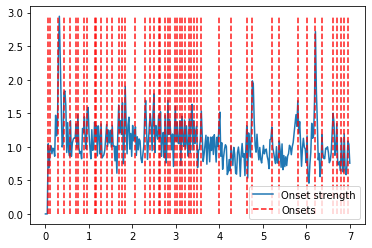

In [38]:
librosa_onsets(join('outputs', wav_lst[0]))

array([  2,   4,  12,  18,  26,  32,  34,  41,  44,  51,  54,  59,  61,
        71,  77,  82,  84,  95, 104, 110, 115, 121, 123, 128, 130, 133,
       138, 141, 144, 146, 149, 154, 156, 159, 161, 164, 186, 199, 215,
       221, 241, 251, 271, 281, 288, 296, 306, 312, 318, 321, 324])

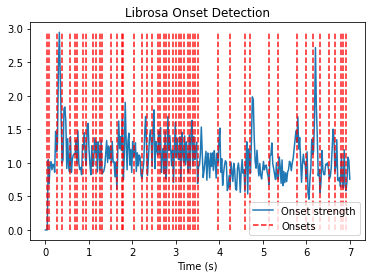

In [43]:
librosa_onsets(join('outputs', wav_lst[0]))  # After backtrack=True

In [46]:
librosa_onsets(join('outputs', wav_lst[0]), mode='time')  # After backtrack=True, 'time'

array([0.04266667, 0.08533333, 0.256     , 0.384     , 0.55466667,
       0.68266667, 0.72533333, 0.87466667, 0.93866667, 1.088     ,
       1.152     , 1.25866667, 1.30133333, 1.51466667, 1.64266667,
       1.74933333, 1.792     , 2.02666667, 2.21866667, 2.34666667,
       2.45333333, 2.58133333, 2.624     , 2.73066667, 2.77333333,
       2.83733333, 2.944     , 3.008     , 3.072     , 3.11466667,
       3.17866667, 3.28533333, 3.328     , 3.392     , 3.43466667,
       3.49866667, 3.968     , 4.24533333, 4.58666667, 4.71466667,
       5.14133333, 5.35466667, 5.78133333, 5.99466667, 6.144     ,
       6.31466667, 6.528     , 6.656     , 6.784     , 6.848     ,
       6.912     ])

In [61]:
librosa_onsets(join('outputs', wav_lst[0]), mode='time')  # After backtrack=True, 'time' with peak_pick args

array([0.04266667, 0.21333333, 0.256     , 0.384     , 1.792     ,
       2.73066667, 2.77333333, 3.11466667, 4.65066667, 4.71466667,
       6.144     ])

In [62]:
lib_count_lst = []

for file in os.listdir('outputs'):
    onset_time = librosa_onsets(join('outputs', file), mode='time')
    lib_count_lst.append((len(onset_time), onset_time.tolist()))
    
print(lib_count_lst)

[(11, [0.042666666666666665, 0.21333333333333335, 0.256, 0.384, 1.792, 2.7306666666666666, 2.7733333333333334, 3.1146666666666665, 4.650666666666667, 4.714666666666667, 6.144]), (21, [0.042666666666666665, 1.472, 1.6213333333333333, 1.728, 1.8346666666666667, 1.8986666666666667, 2.048, 3.6906666666666665, 4.629333333333333, 4.757333333333333, 4.928, 5.738666666666667, 6.101333333333334, 6.144, 6.378666666666667, 6.464, 7.808, 8.426666666666666, 8.768, 9.173333333333334, 9.685333333333332]), (29, [0.042666666666666665, 2.24, 2.3893333333333335, 2.538666666666667, 2.688, 2.752, 3.8186666666666667, 4.032, 5.12, 5.184, 5.290666666666667, 5.354666666666667, 5.504, 5.888, 5.952, 6.208, 6.272, 6.421333333333333, 6.485333333333333, 7.168, 7.36, 7.594666666666667, 7.658666666666667, 8.405333333333333, 8.704, 8.810666666666666, 9.002666666666666, 9.472, 9.962666666666667]), (13, [0.042666666666666665, 0.4266666666666667, 1.28, 1.472, 1.5573333333333332, 2.0906666666666665, 2.1973333333333334, 2.

In [63]:
assert len(lib_count_lst)==len(gt_lst)
lib_error_count = []
lib_error_onset_t = []
for idx, tup in enumerate(lib_count_lst):
    lib_error_count.append(abs(tup[0] - gt_lst[idx][0]))
    # compute onset_t differences of different size
    
print(sum(lib_error_count) / len(lib_error_count))

12.2


## Aubio

In [1]:
def get_onset_times(file_path):
    window_size = 1024 # FFT size
    hop_size = window_size // 4

    sample_rate = 0
    src_func = source(file_path, sample_rate, hop_size)
    sample_rate = src_func.samplerate
    onset_func = onset('default', window_size, hop_size)
    
    duration = float(src_func.duration) / src_func.samplerate

    onset_times = [] # seconds
    while True: # read frames
        samples, num_frames_read = src_func()
        if onset_func(samples):
            onset_time = onset_func.get_last_s()
            if onset_time < duration:
                onset_times.append(onset_time)
            else:
                break
        if num_frames_read < hop_size:
            break
    
    return onset_times

In [7]:
file_path = join('outputs', wav_lst[0])
onset_times = get_onset_times(file_path)

In [11]:
count_lst = []

for file in os.listdir('outputs'):
    onset_time = get_onset_times(join('outputs', file))
    count_lst.append((len(onset_time), onset_time))
    
print(count_lst)

[(10, [0.0, 1.334308385848999, 1.3935147523880005, 1.4508843421936035, 1.511950135231018, 1.5714513063430786, 1.629569172859192, 1.7495918273925781, 1.8089796304702759, 2.099682569503784]), (5, [0.0, 2.517437696456909, 2.5994105339050293, 3.1590023040771484, 3.8524036407470703]), (14, [0.0, 2.8123583793640137, 2.9293878078460693, 2.988616704940796, 3.0461678504943848, 3.10569167137146, 3.1661224365234375, 3.344149589538574, 3.402585029602051, 3.4634695053100586, 4.905079364776611, 4.965396881103516, 5.024625778198242, 5.082766532897949]), (8, [0.0, 0.87034010887146, 1.4771201610565186, 1.5983673334121704, 1.901610016822815, 1.9607256650924683, 2.076326608657837, 2.1402721405029297]), (9, [0.0, 2.7684807777404785, 2.8294103145599365, 2.887460231781006, 2.9454421997070312, 3.0050339698791504, 3.0641496181488037, 3.185147285461426, 3.243197202682495]), (1, [0.0]), (11, [0.0, 0.6227437853813171, 0.6820635199546814, 0.7408390045166016, 0.7993423938751221, 0.8579365015029907, 0.9199319481849

In [3]:
with open('annotations.json') as f:
    anns = json.load(f)

### Ground-truth

In [21]:
gt_lst = []

for file in os.listdir('outputs'):
    key_name = file.split('.')[0]
    
    start_ts = [item['start_t'] for item in anns[key_name]['birds']]
    
    gt_lst.append((anns[key_name]['count'], sorted(start_ts)))
    
print(gt_lst)

[(10, [0.015876305004615496, 0.04055874747533283, 0.8560014930756557, 1.113190095751739, 1.4673785172424894, 1.8090983152621483, 1.9343189066546818, 2.1345905017997007, 4.339293069060367, 5.427446743592197]), (10, [0.37726755844016974, 0.39026541015092964, 0.865730286394628, 1.289283348606935, 1.3144453738689539, 2.045300700875337, 4.526546265432463, 4.606212095954632, 4.9642929183415685, 5.358079898350199]), (10, [2.0422582831429015, 2.4019279826428646, 3.684572612475001, 4.631383724230315, 5.174263512148089, 5.808403381671271, 7.213222444554427, 7.247640891734407, 8.61479029189398, 9.305477105584105]), (10, [0.08957469750368154, 0.7055040435527499, 0.7437540168754013, 1.1322561652724625, 1.1368965504921866, 2.508784130854608, 2.9445331997541864, 3.1993645288836, 3.36240098300053, 4.24348693561246]), (10, [0.7902820896082009, 0.8351156931336404, 0.9657154572200708, 2.8727539475059127, 4.742736772641742, 4.8263467105994025, 6.537025166068086, 7.504311641580494, 7.643364108606821, 7.805

In [22]:
assert len(count_lst)==len(gt_lst)
error_count = []
error_onset_t = []
for idx, tup in enumerate(count_lst):
    error_count.append(abs(tup[0] - gt_lst[idx][0]))
    # compute onset_t differences of different size
    
print(sum(error_count) / len(error_count))

3.6


# Evaluation

In [3]:
# Load annotations
with open(join('annotations_pred.json')) as f:
    anns = json.load(f)

In [4]:
sort_attr = 'PolyphonyLevel'
PR_lst = sorted(anns.items(), key=lambda x: x[1][sort_attr], reverse=True)

In [5]:
len(PR_lst)

20000

In [6]:
count_lst, pl_lst, pa_lst, pr_lst, pd_lst = [], [], [], [], []

for item in PR_lst:
    pl_lst.append(item[1]['PolyphonyLevel'])
    pa_lst.append(item[1]['PolyphonicArea'])
    pr_lst.append(item[1]['PolyphonicRatio'])
    pd_lst.append(item[1]['PolyphonicDensity'])
    count_lst.append(item[1]['count'])

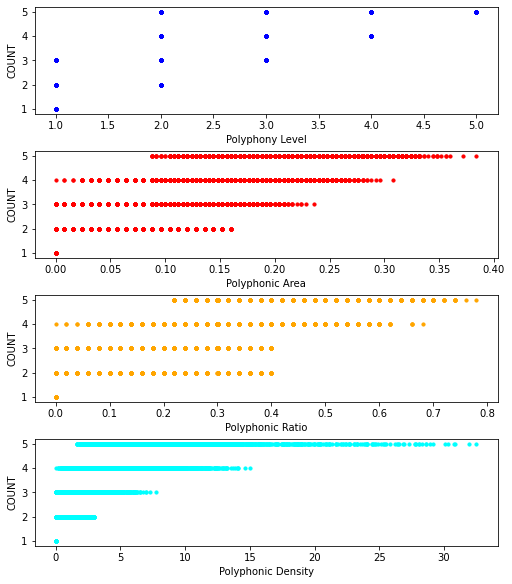

In [7]:
fig, ax = plt.subplots(4, 1, figsize=(7, 8), constrained_layout=True)

ax[0].scatter(pl_lst, count_lst, color='b', s=10)
ax[0].set_xlabel("Polyphony Level")
ax[0].set_ylabel("COUNT")

ax[1].scatter(pa_lst, count_lst, color='r', s=10)
ax[1].set_xlabel("Polyphonic Area")
ax[1].set_ylabel("COUNT")

ax[2].scatter(pr_lst, count_lst, color='orange', s=10)
ax[2].set_xlabel("Polyphonic Ratio")
ax[2].set_ylabel("COUNT")

ax[3].scatter(pd_lst, count_lst, color='cyan', s=10)
ax[3].set_xlabel("Polyphonic Density")
ax[3].set_ylabel("COUNT")

#fig.savefig('ZD20K_distribution', facecolor='white', transparent=False)
plt.show()

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


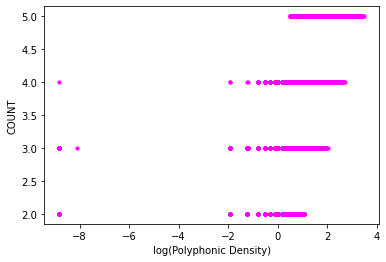

In [8]:
fig2, ax2 = plt.subplots()

ax2.scatter(np.log(pd_lst), count_lst, color='magenta', s=10)
ax2.set_xlabel("log(Polyphonic Density)")
ax2.set_ylabel("COUNT")

#fig2.savefig('ZD20K_log-polyphonicDensity', facecolor='white', transparent=False)
plt.show()

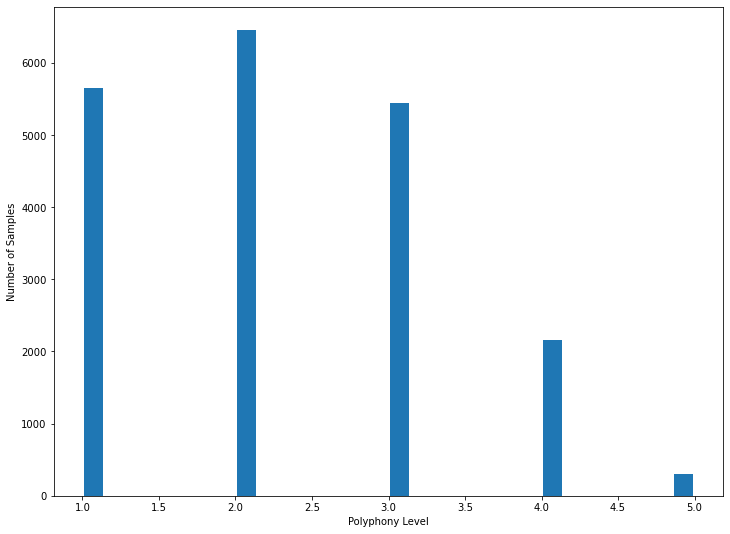

In [9]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(pl_lst, bins='auto', rwidth=0.85)
ax3.set_xlabel("Polyphony Level")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

## Polyphony Level

In [82]:
def eval_polyphony(ann, sort_attr = 'PolyphonyLevel'):
    
    PR_lst = sorted(ann.items(), key=lambda x: x[1][sort_attr], reverse=False)
    
    attr_lst = []
    count_num_pred_lst, count_lst = [], []
    

    for item in PR_lst:
        if item[1]['count_num_pred'] is not None:
            attr_lst.append(item[1][sort_attr])
            count_lst.append(item[1]['count'])
            count_num_pred_lst.append(item[1]['count_num_pred'])
            
            
    print("Number of test samples = ", len(attr_lst))
    
    return attr_lst, count_num_pred_lst, count_lst

In [84]:
X, Y_gt, Y_pred = eval_polyphony(anns, sort_attr = 'PolyphonyLevel')

Number of test samples =  4999


In [50]:
def get_metric(y_gt, y_pred):
    mse_sum = 0
    mde_sum = 0
    acc_sum = 0

    for idx, gt in enumerate(y_gt):
        mse_sum += abs(gt - y_pred[idx])**2
        mde_sum += abs(gt - y_pred[idx])
        if gt == y_pred[idx]:
            acc_sum += 1

    MSE = mse_sum / len(y_gt)
    MDE = mde_sum / len(y_gt)
    Accuracy = acc_sum / len(y_gt)

    print("MSE = %.3f; MDE = %.3f; Accuracy = %.2f%%" % (MSE, MDE, Accuracy*100))
    
    return MSE, MDE, Accuracy

In [52]:
PL_metric = {}

for i in range(1, 6, 1):
    gt, pred = [], []
    for idx, val in enumerate(X):
        if val == i:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx])
    
    mse, mde, accu = get_metric(gt, pred)
    PL_metric[i] = (mse, mde, accu)
    
print(PL_metric)

MSE = 0.010; MDE = 0.010; Accuracy = 98.96%
MSE = 0.084; MDE = 0.084; Accuracy = 91.60%
MSE = 0.199; MDE = 0.199; Accuracy = 80.09%
MSE = 0.282; MDE = 0.282; Accuracy = 71.82%
MSE = 0.247; MDE = 0.247; Accuracy = 75.32%
{1: (0.01043115438108484, 0.01043115438108484, 0.9895688456189151), 2: (0.08395061728395062, 0.08395061728395062, 0.9160493827160494), 3: (0.19909159727479184, 0.19909159727479184, 0.8009084027252081), 4: (0.281767955801105, 0.281767955801105, 0.7182320441988951), 5: (0.24675324675324675, 0.24675324675324675, 0.7532467532467533)}


In [76]:
metric_acc = [item[2] for item in list(PL_metric.values())]
metric_MSE = [item[0] for item in list(PL_metric.values())]
metric_MDE = [item[1] for item in list(PL_metric.values())]

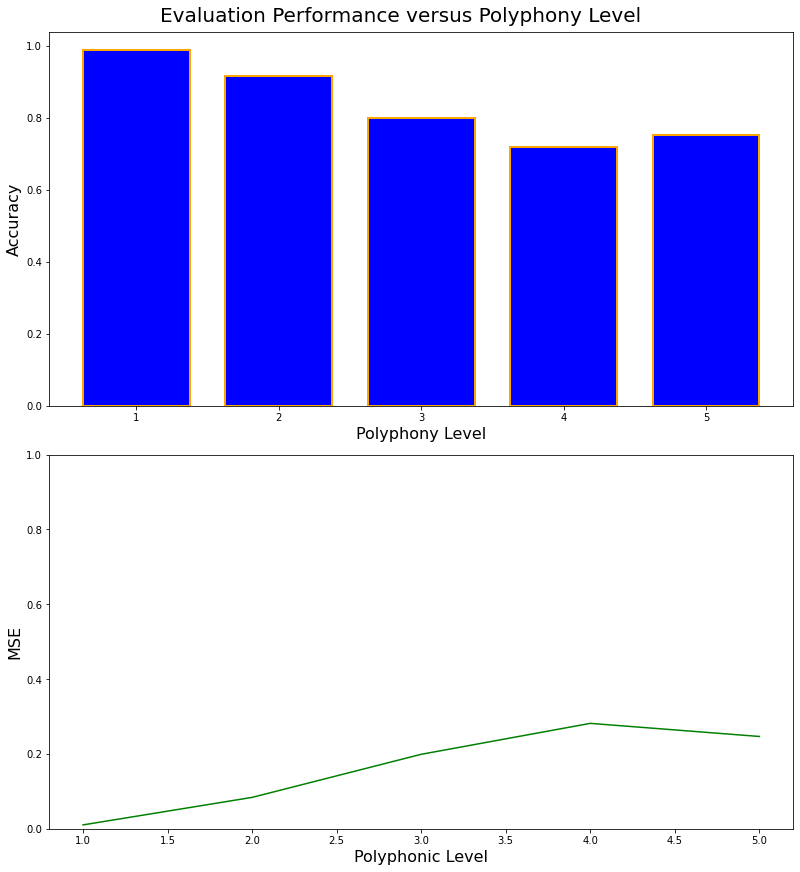

In [108]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)


ax[0].bar(list(PL_metric), metric_acc, color='b', 
       edgecolor='orange', linewidth=2, width=0.75,
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].set_xlabel("Polyphony Level", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)

ax[1].plot(list(PL_metric), metric_MSE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[1].set_xlabel("Polyphonic Level", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim([0, 1])
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Level", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Evaluation Performance versus Polyphony Level", fontsize=20)


plt.show()

## Polyphonic Ratio

In [110]:
X, Y_gt, Y_pred = eval_polyphony(anns, sort_attr = 'PolyphonicRatio')

Number of test samples =  4999


In [96]:
PR_metric = {}

for i in range(0, 10):
    gt, pred = [], []
    for idx, val in enumerate(X):
        if val > i/10 and val <= i/10 + 0.1:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx])
    
    if len(gt) > 1:
        mse, mde, accu = get_metric(gt, pred)
        PR_metric[i/10] = (mse, mde, accu)
    
print(PR_metric)
PR_metric_acc = [item[2] for item in list(PR_metric.values())]
PR_metric_MSE = [item[0] for item in list(PR_metric.values())]
PR_metric_MDE = [item[1] for item in list(PR_metric.values())]

MSE = 0.034; MDE = 0.034; Accuracy = 96.60%
MSE = 0.057; MDE = 0.057; Accuracy = 94.28%
MSE = 0.156; MDE = 0.156; Accuracy = 84.38%
MSE = 0.203; MDE = 0.203; Accuracy = 79.71%
MSE = 0.231; MDE = 0.231; Accuracy = 76.91%
MSE = 0.193; MDE = 0.193; Accuracy = 80.70%
MSE = 0.241; MDE = 0.241; Accuracy = 75.86%
MSE = 0.000; MDE = 0.000; Accuracy = 100.00%
{0.0: (0.033962264150943396, 0.033962264150943396, 0.9660377358490566), 0.1: (0.05719921104536489, 0.05719921104536489, 0.9428007889546351), 0.2: (0.15616438356164383, 0.15616438356164383, 0.8438356164383561), 0.3: (0.20294117647058824, 0.20294117647058824, 0.7970588235294118), 0.4: (0.23087621696801114, 0.23087621696801114, 0.7691237830319889), 0.5: (0.19298245614035087, 0.19298245614035087, 0.8070175438596491), 0.6: (0.2413793103448276, 0.2413793103448276, 0.7586206896551724), 0.7: (0.0, 0.0, 1.0)}


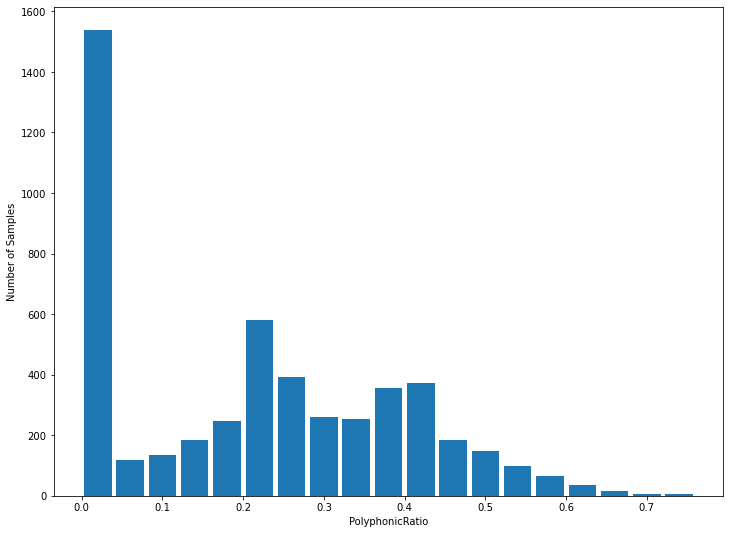

In [89]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicRatio")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

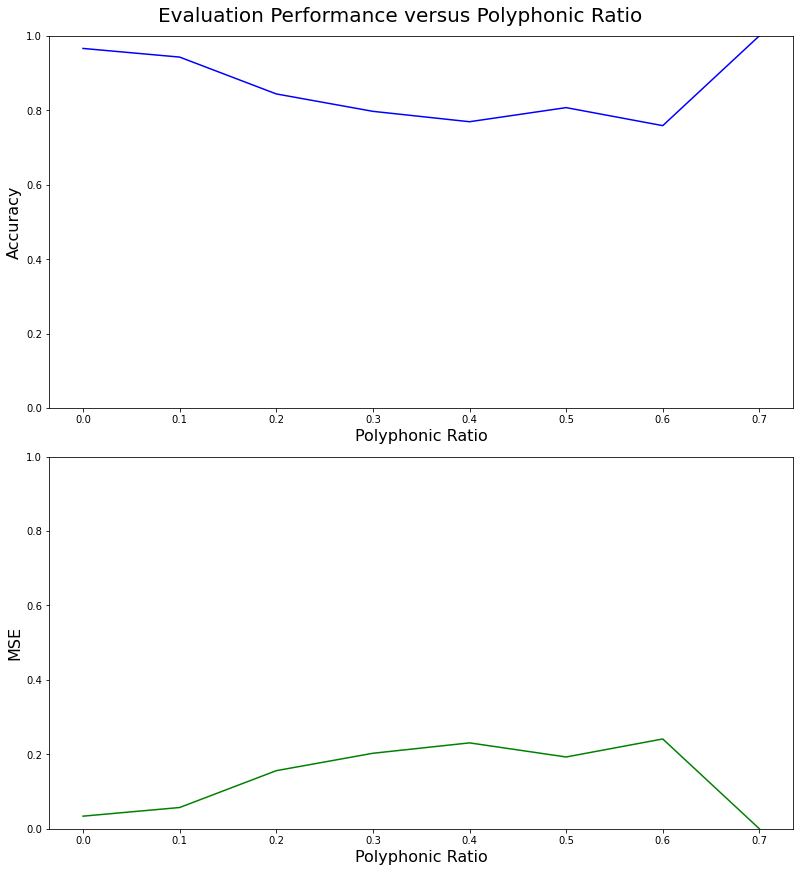

In [109]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)

ax[0].plot(list(PR_metric), PR_metric_acc, color='b', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].set_xlabel("Polyphonic Ratio", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])

ax[1].plot(list(PR_metric), PR_metric_MSE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[1].set_xlabel("Polyphonic Ratio", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim([0, 1])
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Level", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Evaluation Performance versus Polyphonic Ratio", fontsize=20)


plt.show()

## Polyphonic Area

In [111]:
X, Y_gt, Y_pred = eval_polyphony(anns, sort_attr = 'PolyphonicArea')

Number of test samples =  4999


In [115]:
PA_metric = {}
bins = 20

for i in range(0, bins):
    gt, pred = [], []
    for idx, val in enumerate(X):
        if val > i/bins and val <= i/bins + 1/bins:
            gt.append(Y_gt[idx])
            pred.append(Y_pred[idx])
    
    if len(gt) > 1:
        mse, mde, accu = get_metric(gt, pred)
        PA_metric[i/bins] = (mse, mde, accu)
    
print(PA_metric)
PA_metric_acc = [item[2] for item in list(PA_metric.values())]
PA_metric_MSE = [item[0] for item in list(PA_metric.values())]
PA_metric_MDE = [item[1] for item in list(PA_metric.values())]

MSE = 0.040; MDE = 0.040; Accuracy = 96.05%
MSE = 0.093; MDE = 0.093; Accuracy = 90.68%
MSE = 0.160; MDE = 0.160; Accuracy = 84.03%
MSE = 0.220; MDE = 0.220; Accuracy = 78.00%
MSE = 0.265; MDE = 0.265; Accuracy = 73.48%
MSE = 0.213; MDE = 0.213; Accuracy = 78.73%
MSE = 0.083; MDE = 0.083; Accuracy = 91.67%
MSE = 0.000; MDE = 0.000; Accuracy = 100.00%
{0.0: (0.03953488372093023, 0.03953488372093023, 0.9604651162790697), 0.05: (0.09322033898305085, 0.09322033898305085, 0.9067796610169492), 0.1: (0.15974842767295597, 0.15974842767295597, 0.8402515723270441), 0.15: (0.22002820874471085, 0.22002820874471085, 0.7799717912552891), 0.2: (0.26519337016574585, 0.26519337016574585, 0.7348066298342542), 0.25: (0.21266968325791855, 0.21266968325791855, 0.7873303167420814), 0.3: (0.08333333333333333, 0.08333333333333333, 0.9166666666666666), 0.35: (0.0, 0.0, 1.0)}


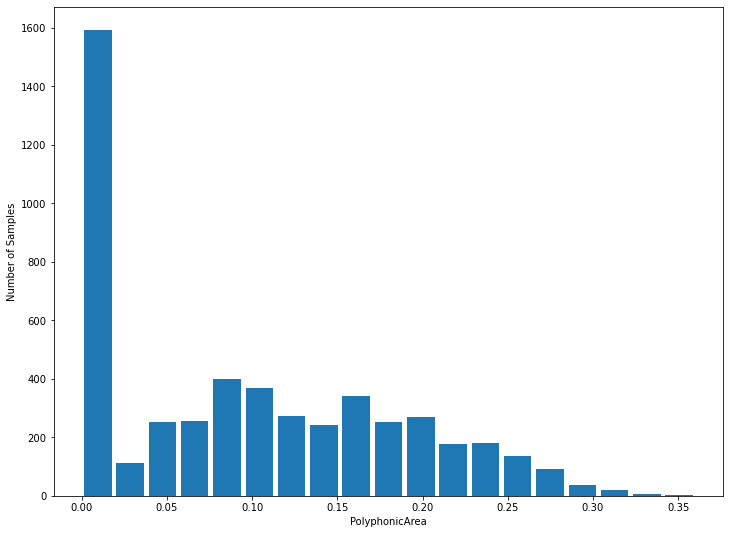

In [113]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicArea")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

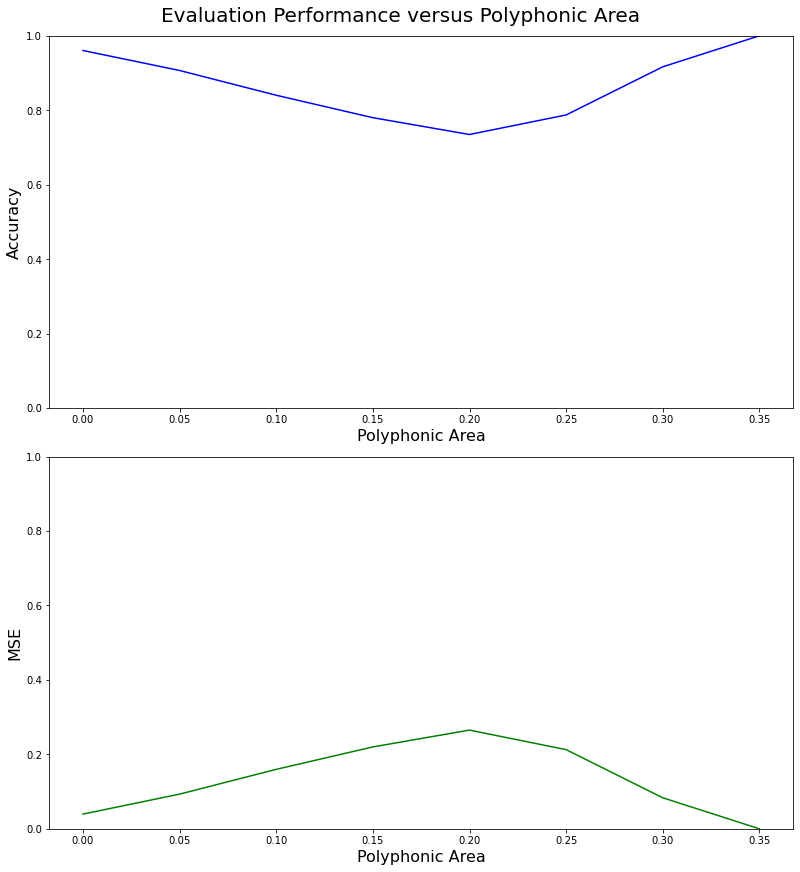

In [117]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)

ax[0].plot(list(PA_metric), PA_metric_acc, color='b', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].set_xlabel("Polyphonic Area", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])

ax[1].plot(list(PA_metric), PA_metric_MSE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[1].set_xlabel("Polyphonic Area", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim([0, 1])
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Area", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Evaluation Performance versus Polyphonic Area", fontsize=20)


plt.show()

## Polyphonic Density

In [118]:
X, Y_gt, Y_pred = eval_polyphony(anns, sort_attr = 'PolyphonicDensity')

Number of test samples =  4999


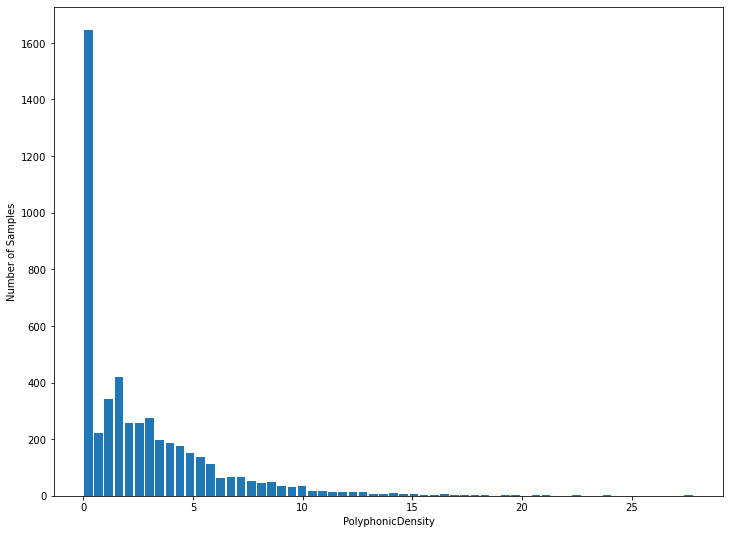

In [119]:
fig3, ax3 = plt.subplots(figsize=(12,9))
ax3.hist(X, bins='auto', rwidth=0.85)
ax3.set_xlabel("PolyphonicDensity")
ax3.set_ylabel("Number of Samples")

#fig3.savefig('ZD20K_hist')
plt.show()

In [127]:
logX = np.log(max(X))
print("Max log(PolyphonicDensity) in the test set is ", logX)

Max log(PolyphonicDensity) in the test set is  3.3260565141508853


In [130]:
PD_metric = {}
bins = 20

for i in range(0, bins):
    gt, pred = [], []
    for idx, val in enumerate(X):
        if val > 0:
            if np.log(val) > i*logX/bins and np.log(val) <= (i/bins + 1/bins)*logX:
                gt.append(Y_gt[idx])
                pred.append(Y_pred[idx])
    
    if len(gt) > 1:
        mse, mde, accu = get_metric(gt, pred)
        PD_metric[i*logX/bins] = (mse, mde, accu)
    
print(PD_metric)
PD_metric_acc = [item[2] for item in list(PD_metric.values())]
PD_metric_MSE = [item[0] for item in list(PD_metric.values())]
PD_metric_MDE = [item[1] for item in list(PD_metric.values())]

MSE = 0.012; MDE = 0.012; Accuracy = 98.84%
MSE = 0.078; MDE = 0.078; Accuracy = 92.19%
MSE = 0.120; MDE = 0.120; Accuracy = 88.04%
MSE = 0.050; MDE = 0.050; Accuracy = 94.97%
MSE = 0.145; MDE = 0.145; Accuracy = 85.50%
MSE = 0.155; MDE = 0.155; Accuracy = 84.52%
MSE = 0.208; MDE = 0.208; Accuracy = 79.25%
MSE = 0.166; MDE = 0.166; Accuracy = 83.40%
MSE = 0.225; MDE = 0.225; Accuracy = 77.45%
MSE = 0.196; MDE = 0.196; Accuracy = 80.38%
MSE = 0.243; MDE = 0.243; Accuracy = 75.66%
MSE = 0.268; MDE = 0.268; Accuracy = 73.20%
MSE = 0.293; MDE = 0.293; Accuracy = 70.75%
MSE = 0.342; MDE = 0.342; Accuracy = 65.79%
MSE = 0.175; MDE = 0.175; Accuracy = 82.54%
MSE = 0.277; MDE = 0.277; Accuracy = 72.34%
MSE = 0.292; MDE = 0.292; Accuracy = 70.83%
MSE = 0.105; MDE = 0.105; Accuracy = 89.47%
MSE = 0.000; MDE = 0.000; Accuracy = 100.00%
MSE = 0.250; MDE = 0.250; Accuracy = 75.00%
{0.0: (0.011627906976744186, 0.011627906976744186, 0.9883720930232558), 0.16630282570754426: (0.078125, 0.078125, 0.921

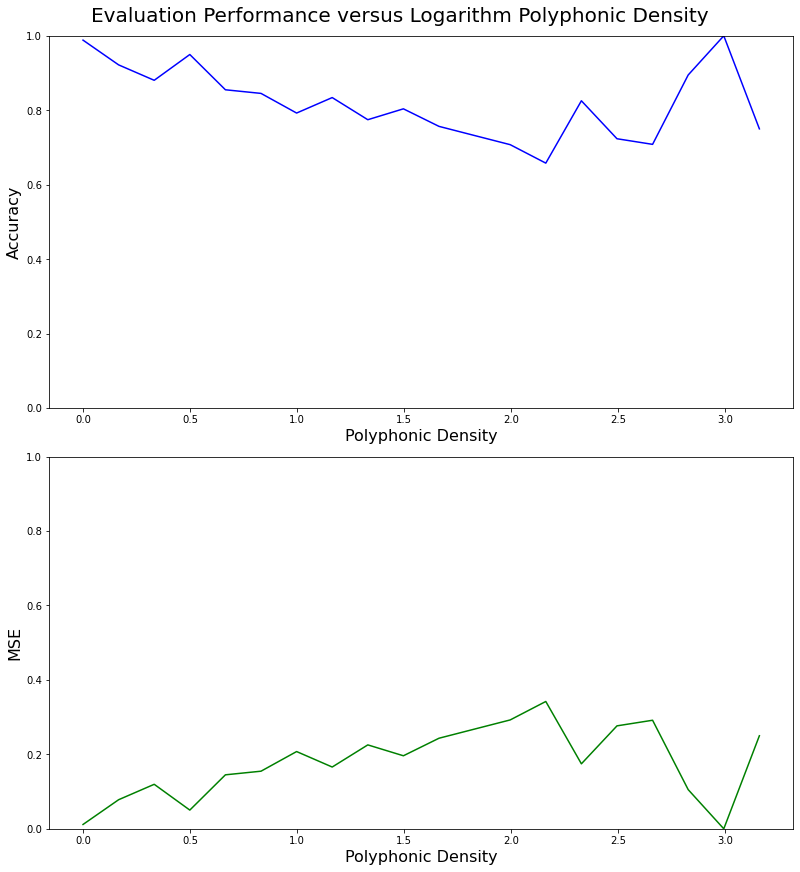

In [132]:
fig, ax = plt.subplots(2, 1, figsize=(11, 12), constrained_layout=True)

ax[0].plot(list(PD_metric), PD_metric_acc, color='b', 
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[0].set_xlabel("Polyphonic Density", fontsize=16)
ax[0].set_ylabel("Accuracy", fontsize=16)
ax[0].set_ylim([0, 1])

ax[1].plot(list(PD_metric), PD_metric_MSE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[1].set_xlabel("Polyphonic Density", fontsize=16)
ax[1].set_ylabel("MSE", fontsize=16)
ax[1].set_ylim([0, 1])
'''
ax[2].plot(list(PL_metric), metric_MDE, color='g',
      #yerr=[-0.1, -0.05, 0.01, 0.03, 0.2],
      )
ax[2].set_xlabel("Polyphonic Area", fontsize=16)
ax[2].set_ylabel("MDE", fontsize=16)
ax[2].set_ylim([0, 1])
'''
fig.suptitle("Evaluation Performance versus Logarithm Polyphonic Density", fontsize=20)


plt.show()